In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import IPython.display as ipd
import os, glob
from librosa.feature import rms, zero_crossing_rate, mfcc
from reservoirpy.nodes import Reservoir, ESN, Ridge
from tqdm import tqdm
from numpy import hanning, convolve
from numpy.fft import fft, fftshift

#### Importing and pre-processing data

In [3]:
input_dir = './dataset/ESC-10'
subdirs = os.listdir(input_dir)
subdirs.sort()
labels = []
data = []
sample_rate = 22050
for label ,folder in tqdm(enumerate(subdirs), desc='Loading data', total=len(subdirs)):
    for file in glob.glob(input_dir + '/' + folder + '/*.ogg'):
        x = librosa.load(file, sr=sample_rate)[0]
        labels.append(label)
        data.append(x)

Loading data: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


### Sample data and Time feature visualization

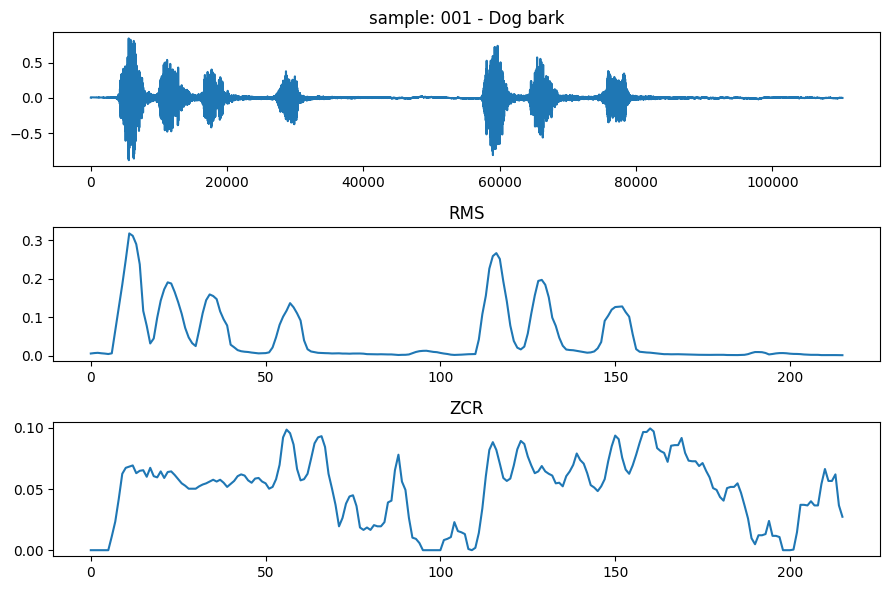

In [4]:
fig , ax = plt.subplots(nrows=3, ncols=1,figsize=(9,6))
ax[0].plot(data[10])
ax[0].set_title('sample: ' + subdirs[labels[10]])
ax[1].plot(rms(y=data[10]).reshape(-1,1))
ax[1].set_title('RMS')
ax[2].plot(zero_crossing_rate(y=data[10]).reshape(-1,1))
ax[2].set_title('ZCR')
plt.tight_layout()
plt.show()

### MFCC

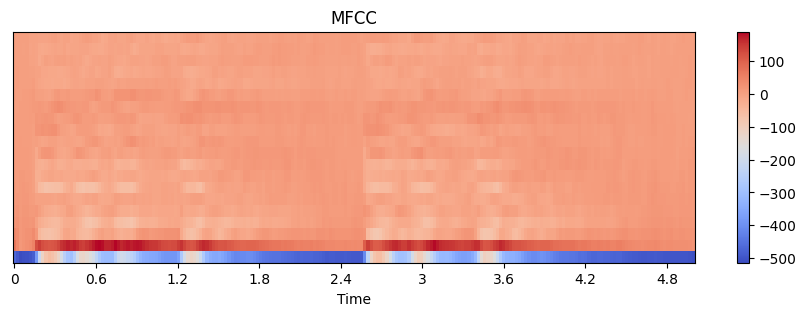

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,3))
mfccs =mfcc(y=data[10], sr=sample_rate)
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
plt.title('MFCC')
plt.show()

#### Window

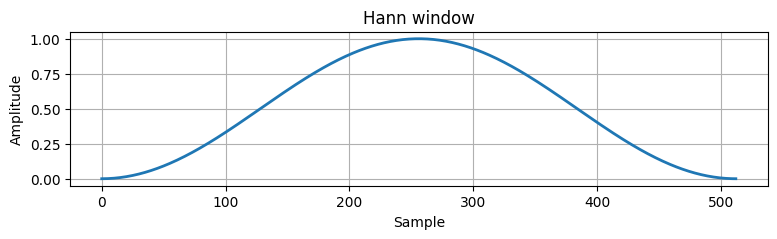

In [6]:
window = hanning(513)
plt.figure(figsize=(9,2))
plt.plot(window, label="Hann window", linewidth=2)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.grid()
plt.show()

### applying window


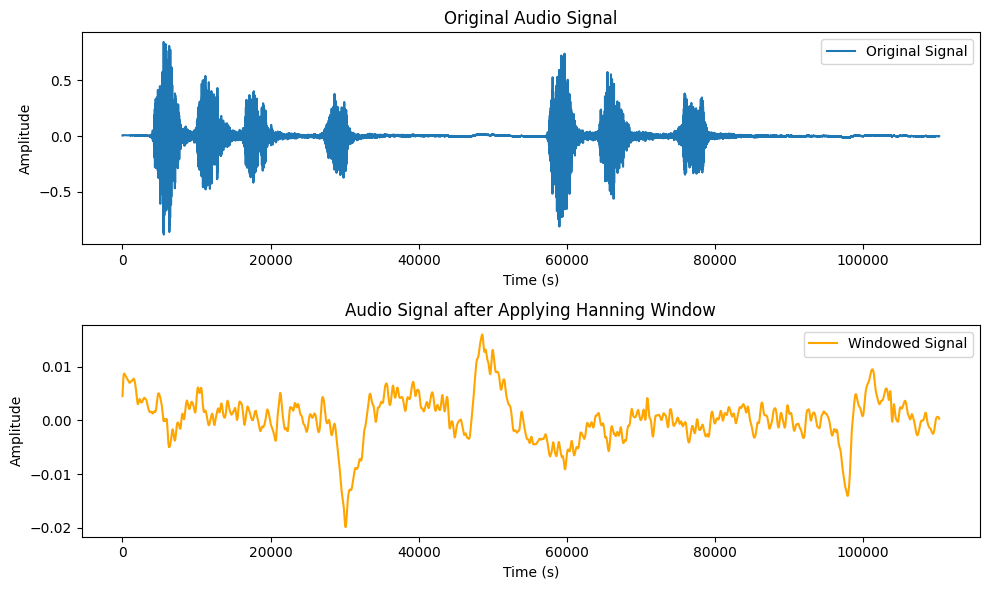

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hann, convolve


audio_signal = data[10]

# Apply Hanning window
window_size = 513
hanning_window = hanning(window_size)

# Apply the window to the audio signal
windowed_signal = convolve(audio_signal, hanning_window, mode='same') / sum(hanning_window)

# Plot the original and windowed signals
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot( audio_signal, label='Original Signal')
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot( windowed_signal, label='Windowed Signal', color='orange')
plt.title('Audio Signal after Applying Hanning Window')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


## ESN Reservoir

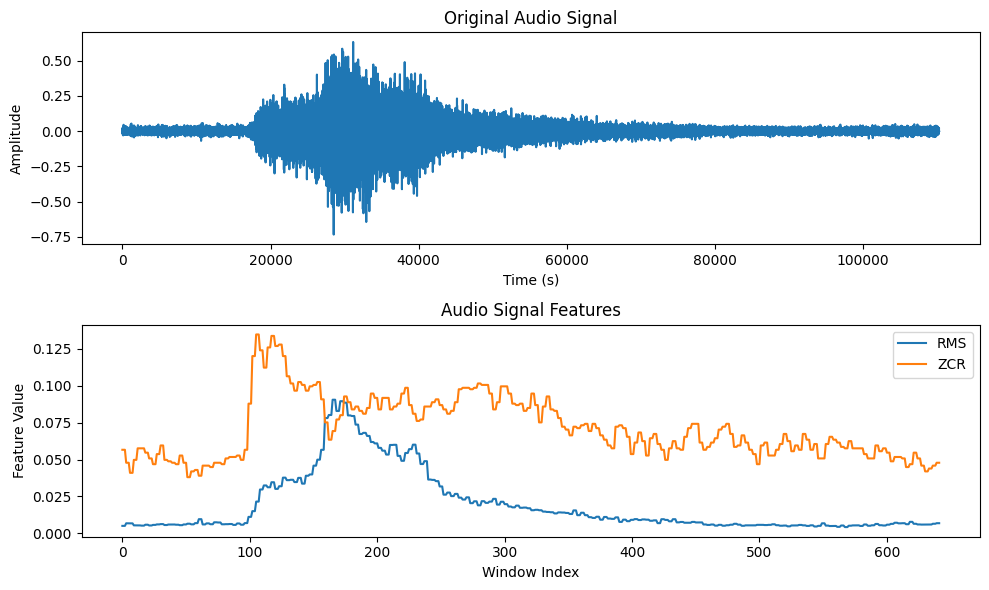

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import os
import glob
from librosa.feature import rms, zero_crossing_rate
from reservoirpy.nodes import Reservoir, Ridge
from tqdm import tqdm
from numpy import hanning, convolve

def apply_sliding_window(signal, window_size, overlap):
    num_samples = len(signal)
    step_size = window_size - overlap
    num_windows = int((num_samples - window_size) / step_size) + 1
    windows = np.zeros((num_windows, window_size))

    for i in range(num_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_size
        windows[i, :] = signal[start_idx:end_idx] * hanning(window_size)

    return windows

def extract_audio_features(signal,label, window_size, overlap):
    windowed_signals = apply_sliding_window(signal, window_size, overlap)
    features = []
    l = []
    for window in windowed_signals:
        rms_features = np.array([rms(y=window)]).ravel()
        zcr_features = np.array([zero_crossing_rate(y=window)]).ravel()
        features.append(np.c_[rms_features, zcr_features])
        l.append(np.zeros_like(rms_features)+label)
    return np.array(features),  np.array(l)


sample_idx = 110
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(data[sample_idx])
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.subplot(2, 1, 2)
plt.plot(extract_audio_features(data[sample_idx],labels[sample_idx] ,1024, 512)[0].reshape(-1,2), label=['RMS', 'ZCR'])
plt.title('Audio Signal Features')
plt.xlabel('Window Index')
plt.ylabel('Feature Value')
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)
esn_model = reservoir >> ridge

X =[]
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)
    X.append(features)
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)

print(X.shape)
print(y.shape)

(85727, 3, 2)
(85727, 3)


Running Reservoir-1:   0%|          | 0/3 [00:00<?, ?it/s]

Running Reservoir-1: 100%|██████████| 3/3 [00:00<00:00, 960.23it/s]

(3, 100)


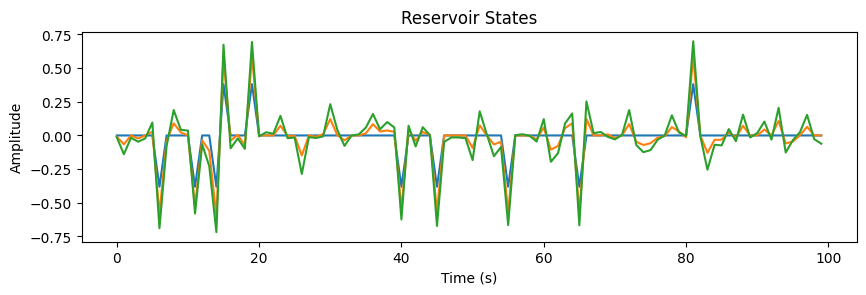

In [10]:
reservoir = Reservoir(100, lr=0.5, sr=0.9)

states = reservoir.run(X[0])
print(states.shape)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(states.T)
plt.title('Reservoir States')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [11]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print(X.shape)
print(y.shape)

# Flatten the data if needed
X = X.reshape(-1, 2)  # Adjust the reshape based on your actual data structure
y = y.reshape(-1, 1).flatten()  # Adjust the reshape based on your actual data structure

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random SVM classifier
clf = svm.SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


(85727, 3, 2)
(85727, 3)
Accuracy: 0.3040418375877287


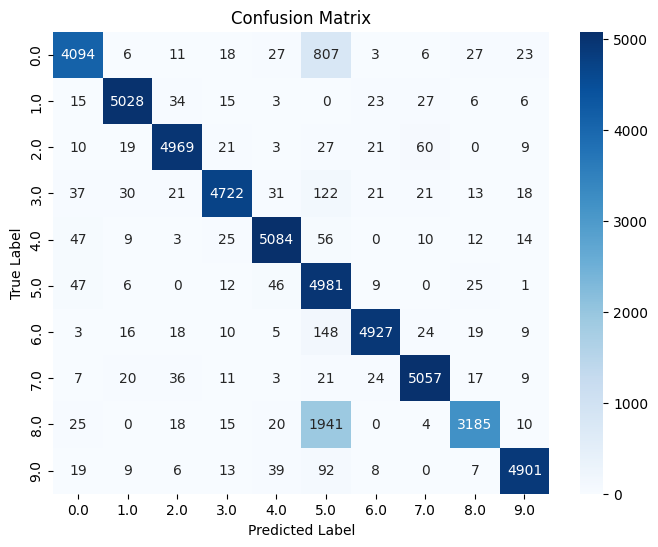

Accuracy: 0.9127281917685712


In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the random forest classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print("Accuracy:", accuracy)


In [13]:
from sklearn.model_selection import train_test_split

# Load extracted features and corresponding labels
def load_data_and_labels(features_dir, labels):
    data = []
    for label, folder in enumerate(labels):
        for file in glob.glob(os.path.join(features_dir, f'{folder}/*.npy')):
            features = np.load(file)
            data.append((features, label))
    return data

# Constants
features_dir = './dataset/ESC-10_features'
data = load_data_and_labels(features_dir, labels)
print(f"Number of samples: {len(data)}")
# Flatten the features and labels
X, y = zip(*data)
X = np.vstack(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the reservoir and ridge regression model
reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)
esn_model = reservoir >> ridge

# Feed the training data to the reservoir
for features, label in zip(X_train, y_train):
    reservoir_output = reservoir(features)

# Train the ridge regression model
esn_model.train(X_train, y_train)

# Evaluate the model on the test set
accuracy = esn_model.evaluate(X_test, y_test)
print(f"Accuracy on test set: {accuracy}")


Number of samples: 0


ValueError: not enough values to unpack (expected 2, got 0)

In RKCCA, the matrices `Z1` and `Z2` are typically constructed as follows:

1. $$ Z_1 = \begin{bmatrix} 0 & KR_X \\ KR_Y & 0 \end{bmatrix} $$


2. $$ Z_2 = \begin{bmatrix} \lambda_1 K_{RX}^2 - \eta \lambda I & 0 \\ 0 & \lambda_2 K_{RY}^2 - \eta \lambda I \end{bmatrix} $$

Here's an updated version of the code that ensures \( Z_1 \) and \( Z_2 \) are square matrices:
 

In [ ]:
import numpy as np
from scipy.linalg import eigh

def calculate_reservoir_kernel(X, Y, gamma):
    kernel_matrix = np.exp(-gamma * np.linalg.norm(X - Y, axis=1)**2)
    return kernel_matrix

def solve_rkcca(X, Y, gamma, lambda_val, eta, alpha, beta):
    # Calculate reservoir kernels
    KR_X = calculate_reservoir_kernel(X, X, gamma)
    KR_Y = calculate_reservoir_kernel(Y, Y, gamma)
    KR_XY = calculate_reservoir_kernel(X, Y, gamma)

    # Construct matrix Z1
    Z1 = np.block([
        [np.zeros((KR_XY.shape[1], KR_XY.shape[1])), KR_XY],
        [KR_XY.T, np.zeros((KR_XY.shape[1], KR_XY.shape[1]))]
    ])

    # Construct matrix Z2
    Z2 = np.block([
        [lambda_val * np.eye(KR_XY.shape[0]), np.zeros_like(KR_XY)],
        [np.zeros_like(KR_XY), lambda_val * np.eye(KR_XY.shape[0])]
    ])

    # Calculate correlation coefficients
    delta = np.array([alpha, beta])

    # Solve the generalized eigenvalue problem using eigh
    eigenvalues, eigenvectors = np.linalg.eigh(Z1, b=Z2)

    # Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Get the canonical variables
    U = eigenvectors[:KR_X.shape[0], :]
    V = eigenvectors[KR_X.shape[0]:, :]

    return U, V, eigenvalues

# Example usage
# Set your X and Y appropriately before calling the function
# X, Y = ...
X = np.random.rand(100, 50)
Y = np.random.rand(100, 50)
# Parameters
gamma = 1.0
lambda_val = 0.1
eta = 0.1
alpha = 1.0
beta = 1.0

# Solve the RKCCA problem
U, V, eigenvalues = solve_rkcca(X, Y, gamma, lambda_val, eta, alpha, beta)

# Print the canonical variables and eigenvalues
print("Canonical Variables U:")
print(U)
print("\nCanonical Variables V:")
print(V)
print("\nEigenvalues:")
print(eigenvalues)


IndexError: tuple index out of range

In [ ]:
import numpy as np

class ReadoutModel:
    def __init__(self, W_out, bias):
        self.W_out = W_out
        self.bias = bias

def calculate_distance(A1, A2, gamma=1.0):
    """
    Calculate the L2 distance between two readout models A1 and A2.

    Parameters:
    - A1, A2: ReadoutModel instances.
    - gamma: Scaling parameter for the distance calculation.

    Returns:
    - Distance between A1 and A2.
    """
    W_diff = A1.W_out - A2.W_out
    distance_squared = np.sum(W_diff**2) + np.sum(A1.bias - A2.bias)**2
    return np.exp(-gamma * distance_squared)

def construct_reservoir_kernel(readout_models, gamma=1.0):
    """
    Construct the reservoir kernel matrix for RKCCA based on readout models.

    Parameters:
    - readout_models: List of ReadoutModel instances.
    - gamma: Scaling parameter for the distance calculation.

    Returns:
    - Reservoir kernel matrix.
    """
    num_models = len(readout_models)
    reservoir_kernel = np.zeros((num_models, num_models))

    for i in range(num_models):
        for j in range(num_models):
            reservoir_kernel[i, j] = calculate_distance(readout_models[i], readout_models[j], gamma)

    return reservoir_kernel

# Example usage:
# Assume A1 and A2 are readout models with weight matrices W_out1 and W_out2, and biases d1 and d2.
# You need to replace these with your actual readout models.
A1 = ReadoutModel(np.random.rand(10, 5), np.random.rand(5))
A2 = ReadoutModel(np.random.rand(10, 5), np.random.rand(5))

# Construct reservoir kernel matrix
gamma_value = 0.1  # You can adjust this parameter
reservoir_kernel_matrix = construct_reservoir_kernel([A1, A2], gamma=gamma_value)

# Print the reservoir kernel matrix
print("Reservoir Kernel Matrix:")
print(reservoir_kernel_matrix)

Reservoir Kernel Matrix:
[[1.         0.32911881]
 [0.32911881 1.        ]]
